In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))


plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name)
tf.test.is_gpu_available()

Tensorflow version: 2.0.0


2021-12-08 21:30:38.156324: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-12-08 21:30:38.192176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2021-12-08 21:30:38.199595: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556d59053600 executing computations on platform Host. Devices:
2021-12-08 21:30:38.199646: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2021-12-08 21:30:38.201366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-08 21:30:40.410855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:1b:00.0
2021-12-08 21:30:40.417860: I tensorflow/core/c

/device:GPU:0


2021-12-08 21:30:40.619514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Adding visible gpu devices: 0, 1, 2, 3, 4, 5, 6, 7
2021-12-08 21:30:40.620693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-08 21:30:40.620711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      0 1 2 3 4 5 6 7 
2021-12-08 21:30:40.620716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 0:   N Y Y Y Y Y Y Y 
2021-12-08 21:30:40.620720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 1:   Y N Y Y Y Y Y Y 
2021-12-08 21:30:40.620724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 2:   Y Y N Y Y Y Y Y 
2021-12-08 21:30:40.620728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 3:   Y Y Y N Y Y Y Y 
2021-12-08 21:30:40.620733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 4:   Y Y Y Y N Y Y Y 
2021-12-08 21:30:40.620739: I tensorflow/core/common_runtime/gpu/gpu_devi

True

## Hyperparameters

In [2]:
# import tushare as ts
# pro = ts.pro_api('f198ddf6f6c8918413793b567bed6269e931f433abd746b26a3c2668')
# dd = pro.daily(ts_code='000001.SZ', start_data='20180701', end_data='20201119')
# dd.to_csv('pro001.csv')

In [3]:
batch_size = 128
seq_len = 128
d_k = 32
d_v = 32
n_heads = 32
ff_dim = 256

## Load Tesla data

In [4]:
# TSLA_path = '../dataset/TSLA.csv'

# df = pd.read_csv(TSLA_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close','Adj Close','Volume'])

# # Replace 0 to avoid dividing by 0 later on
# df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
# df.sort_values('Date', inplace=True)
# df.tail()

In [5]:
# df.drop(labels='Adj Close',axis=1,inplace=True)
# df.head()

## Plot daily Tesla closing prices and volume

In [6]:
# fig = plt.figure(figsize=(15,10))
# st = fig.suptitle("Tesla Close Price and Volume", fontsize=20)
# st.set_y(0.92)

# ax1 = fig.add_subplot(211)
# ax1.plot(df['Close'], label='Tesla Close Price')
# ax1.set_xticks(range(0, df.shape[0], 1464))
# ax1.set_xticklabels(df['Date'].loc[::1464])
# ax1.set_ylabel('Close Price', fontsize=18)
# ax1.legend(loc="upper left", fontsize=12)

# ax2 = fig.add_subplot(212)
# ax2.plot(df['Volume'], label='Tesla Volume')
# ax2.set_xticks(range(0, df.shape[0], 1464))
# ax2.set_xticklabels(df['Date'].loc[::1464])
# ax2.set_ylabel('Volume', fontsize=18)
# ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [7]:
# '''Calculate percentage change'''

# # df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
# # df['High'] = df['High'].pct_change() # Create arithmetic returns column
# # df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
# # df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
# # df['Volume'] = df['Volume'].pct_change()

# df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

# ###############################################################################
# '''Create indexes to split dataset'''

# # times = sorted(df.index.values)
# # last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
# # last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

# ###############################################################################
# '''Normalize price columns'''
# #
# # min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
# # max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# # Min-max normalize price columns (0-1 range)
# # df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
# # df['High'] = (df['High'] - min_return) / (max_return - min_return)
# # df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
# # df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

# ###############################################################################
# '''Normalize volume column'''

# # min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
# # max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# # Min-max normalize volume columns (0-1 range)
# # df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

# ###############################################################################
# '''Create training, validation and test split'''

# df_train = df[(df.index < 221)]  # Training data are 80% of total data
# # df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
# df_test = df

# # Remove date column
# df_train.drop(columns=['Date'], inplace=True)
# # df_val.drop(columns=['Date'], inplace=True)
# df_test.drop(columns=['Date'], inplace=True)

# # Convert pandas columns into arrays
# train_data = df_train.values
# # val_data = df_val.values
# test_data = df_test.values
# print('Training data shape: {}'.format(train_data.shape))
# # print('Validation data shape: {}'.format(val_data.shape))
# print('Test data shape: {}'.format(test_data.shape))

# df_train.head()

## Plot daily changes of close prices and volume

In [8]:
# fig = plt.figure(figsize=(15,12))
# st = fig.suptitle("Data Separation", fontsize=20)
# st.set_y(0.95)

# ###############################################################################

# ax1 = fig.add_subplot(211)
# ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

# # ax1.plot(np.arange(train_data.shape[0], 
# #                    train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

# ax1.plot(np.arange(train_data.shape[0], 
#                    train_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Closing Returns')
# ax1.set_title("Close Price", fontsize=18)
# ax1.legend(loc="best", fontsize=12)

# ###############################################################################

# ax2 = fig.add_subplot(212)
# ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

# # ax2.plot(np.arange(train_data.shape[0], 
# #                    train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

# ax2.plot(np.arange(train_data.shape[0], 
#                    train_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
# ax2.set_xlabel('Date')
# ax2.set_ylabel('Normalized Volume Changes')
# ax2.set_title("Volume", fontsize=18)
# ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [9]:
# # Training data
# X_train, y_train = [], []
# for i in range(seq_len, len(train_data)):
#   X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
# X_train, y_train = np.array(X_train), np.array(y_train)

# ###############################################################################

# # Validation data
# # X_val, y_val = [], []
# # for i in range(seq_len, len(val_data)):
# #     X_val.append(val_data[i-seq_len:i])
# #     y_val.append(val_data[:, 3][i])
# # X_val, y_val = np.array(X_val), np.array(y_val)

# ###############################################################################

# # Test data
# X_test, y_test = [], []
# for i in range(seq_len, len(test_data)):
#     X_test.append(test_data[i-seq_len:i])
#     y_test.append(test_data[:, 3][i])    
# X_test, y_test = np.array(X_test), np.array(y_test)

# print('Training set shape', X_train.shape, y_train.shape)
# # print('Validation set shape', X_val.shape, y_val.shape)
# print('Testing set shape' ,X_test.shape, y_test.shape)

In [10]:
# y_test,df.tail()

## TimeVector

In [11]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [12]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_se1 = Conv1D(filters=self.ff_dim//2, kernel_size=1)
    self.ff_conv1D_se2 = Conv1D(filters=self.ff_dim, kernel_size=1,activation='sigmoid')
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    aa_layer = self.ff_conv1D_se1(ff_layer)
    aa_layer = self.ff_dropout(aa_layer)
    aa_layer = self.ff_conv1D_se2(aa_layer)
    aa_layer = self.ff_dropout(aa_layer)
    ff_layer = aa_layer+ff_layer
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [13]:
# def create_model():
#   '''Initialize time and transformer layers'''
#   time_embedding = Time2Vector(seq_len)
#   attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

#   '''Construct model'''
#   in_seq = Input(shape=(seq_len, 5))
#   x = time_embedding(in_seq)
#   x = Concatenate(axis=-1)([in_seq, x])
#   x = attn_layer1((x, x, x))
#   x = attn_layer2((x, x, x))
#   x = attn_layer3((x, x, x))
#   x = GlobalAveragePooling1D(data_format='channels_first')(x)
#   x = Dropout(0.1)(x)
#   x = Dense(64, activation='relu')(x)
#   x = Dropout(0.1)(x)
#   out = Dense(1, activation='linear')(x)

#   model = Model(inputs=in_seq, outputs=out)
#   model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
#   return model


# model = create_model()
# model.summary()

# # callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
# #                                               monitor=None, 
# #                                               save_best_only=False, verbose=1)

# history = model.fit(X_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=500, )
#                     # validation_data=(X_val, y_val)) 
# model.save('./Transformer+TimeEmbedding.hdf5')
# model = tf.keras.models.load_model('./Transformer+TimeEmbedding.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector, 
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder})


# ###############################################################################
# '''Calculate predictions and metrics'''

# #Calculate predication for training, validation and test data
# train_pred = model.predict(X_train)
# # val_pred = model.predict(X_val)
# test_pred = model.predict(X_test)

# #Print evaluation metrics for all datasets
# train_eval = model.evaluate(X_train, y_train, verbose=0)
# # val_eval = model.evaluate(X_val, y_val, verbose=0)
# test_eval = model.evaluate(X_test, y_test, verbose=0)
# print(' ')
# print('Evaluation metrics')
# print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
# # print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
# print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

# ###############################################################################
# '''Display results'''

# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(train_data[:, 3], label='Tesla Closing Returns')
# ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Tesla Closing Returns')
# ax11.set_title("Training Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('Tesla Closing Returns')
# ax11.legend(loc="best", fontsize=12)

# # #Plot validation data results
# # ax21 = fig.add_subplot(312)
# # ax21.plot(val_data[:, 3], label='Tesla Closing Returns')
# # ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Tesla Closing Returns')
# # ax21.set_title("Validation Data", fontsize=18)
# # ax21.set_xlabel('Date')
# # ax21.set_ylabel('Tesla Closing Returns')
# # ax21.legend(loc="best", fontsize=12)

# #Plot test data results
# ax31 = fig.add_subplot(313)
# ax31.plot(test_data[:, 3], label='Tesla Closing Returns')
# ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Tesla Closing Returns')
# ax31.set_title("Test Data", fontsize=18)
# ax31.set_xlabel('Date')
# ax31.set_ylabel('Tesla Closing Returns')
# ax31.legend(loc="best", fontsize=12)

## Model metrics

In [14]:
# '''Display model metrics'''

# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
# st.set_y(0.92)

# #Plot model loss
# ax1 = fig.add_subplot(311)
# ax1.plot(history.history['loss'], label='Training loss (MSE)')
# # ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
# ax1.set_title("Model loss", fontsize=18)
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss (MSE)')
# ax1.legend(loc="best", fontsize=12)

# #Plot MAE
# ax2 = fig.add_subplot(312)
# ax2.plot(history.history['mae'], label='Training MAE')
# # ax2.plot(history.history['val_mae'], label='Validation MAE')
# ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Mean average error (MAE)')
# ax2.legend(loc="best", fontsize=12)

# #Plot MAPE
# ax3 = fig.add_subplot(313)
# ax3.plot(history.history['mape'], label='Training MAPE')
# # ax3.plot(history.history['val_mape'], label='Validation MAPE')
# ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
# ax3.set_xlabel('Epoch')
# ax3.set_ylabel('Mean average percentage error (MAPE)')
# ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [15]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="Tesla_Transformer+TimeEmbedding.png",
#     show_shapes=True,
#     show_layer_names=True,
#     expand_nested=True,
#     dpi=96,)

# Moving Average

## Moving Average - Load Tesla data again, to apply rolling window

In [16]:
# test_size = 30

In [17]:
# from sklearn.preprocessing import MinMaxScaler
# Tesla_path = '../dataset/TSLA.csv'
# df = pd.read_csv(Tesla_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close','Adj Close','Volume'])
# df.head()




In [18]:
# minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
# df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
# df_log = pd.DataFrame(df_log)
# df_log.head()

In [19]:
# df_train = df_log.iloc[:-test_size]
# df_test = df_log.iloc[-test_size:]
# df.shape, df_train.shape, df_test.shape

In [20]:
Tesla_path = '/home/changjiang_2/BDA/Stock-Prediction-Models-master/deep-learning/pro001.csv'
df = pd.read_csv(Tesla_path, delimiter=',', usecols=['ts_code','Date','Open','High','Low','Close','pre_close','change','pct_chg','Volume','amount'])
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df['pct_chg'].replace(to_replace=0, method='ffill', inplace=True)
df['change'].replace(to_replace=0, method='ffill', inplace=True)
df['amount'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values('Date', inplace=True)
df.drop(labels='ts_code',axis=1,inplace=True)
# df.drop(labels='pre_close',axis=1,inplace=True)
# df.drop(labels='pct_chg',axis=1,inplace=True)
# df.drop(labels='change',axis=1,inplace=True)
# df.drop(labels='amount',axis=1,inplace=True)
# df[['Open', 'High', 'Low', 'Close','Volume']] = df[['Open', 'High', 'Low', 'Close','Volume']].rolling(10).mean()
# df.drop('index')
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount
3998,20041115,7.02,7.20,7.02,7.10,7.01,0.09,1.28,32894.90,23379.8239
3997,20041116,7.13,7.25,7.12,7.20,7.10,0.10,1.41,51791.08,37169.8243
3996,20041117,7.21,7.25,7.05,7.07,7.20,-0.13,-1.81,26569.19,18883.9097
3995,20041118,7.08,7.20,7.04,7.19,7.07,0.12,1.70,30271.50,21573.2982
3994,20041119,7.22,7.50,7.22,7.41,7.19,0.22,3.06,149050.44,109945.7193


In [21]:
# Tesla_path = '../dataset/TSLA.csv'

# df = pd.read_csv(Tesla_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close','Adj Close','Volume'])
# df.drop(labels='Adj Close',axis=1,inplace=True)
# # Replace 0 to avoid dividing by 0 later on
# df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
# df.sort_values('Date', inplace=True)

# # Apply moving average with a window of 10 days to all columns
# df[['Open', 'High', 'Low', 'Close','Volume']] = df[['Open', 'High', 'Low', 'Close','Volume']].rolling(10).mean() 

# # Drop all rows with NaN values
# df.dropna(how='any', axis=0, inplace=True) 
# df.head()

## Moving Average - Plot daily Tesla closing prices and volume

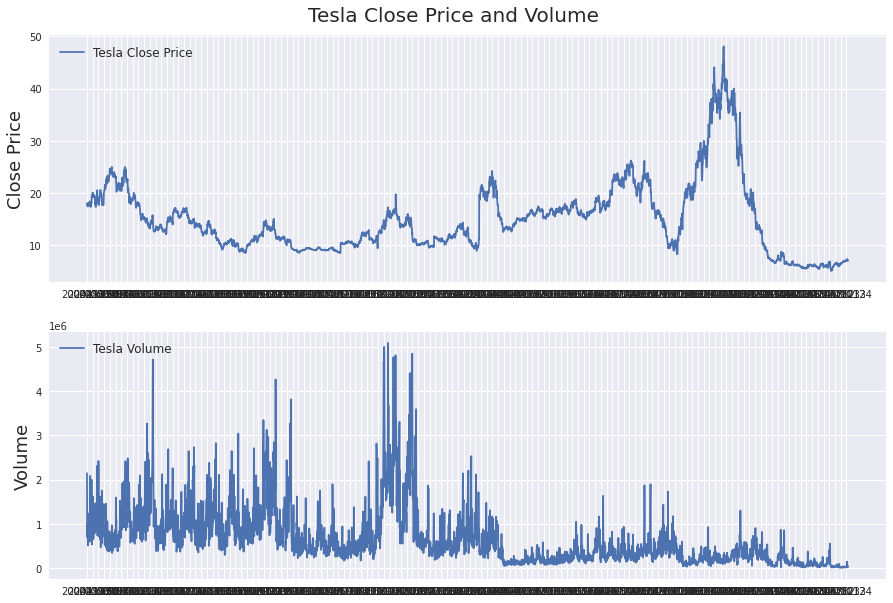

In [22]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Tesla Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Tesla Close Price')
ax1.set_xticks(range(0, df.shape[0], 30))
ax1.set_xticklabels(df['Date'].loc[::30])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Tesla Volume')
ax2.set_xticks(range(0, df.shape[0], 30))
ax2.set_xticklabels(df['Date'].loc[::30])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Moving Average - Calculate normalized percentage change for all columns

In [23]:
# '''Calculate percentage change'''

# # df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
# # df['High'] = df['High'].pct_change() # Create arithmetic returns column
# # df['Low'] = df['Low'].pct_change()# Create arithmetic returns column
# # df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
# # df['Volume'] = df['Volume'].pct_change()

# df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

# ###############################################################################
# '''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

# ###############################################################################
# '''Normalize price columns'''
# #
# min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
# max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# # Min-max normalize price columns (0-1 range)
# df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
# df['High'] = (df['High'] - min_return) / (max_return - min_return)
# df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
# df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

# ###############################################################################
# '''Normalize volume column'''

# min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
# max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# # Min-max normalize volume columns (0-1 range)
# df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[df.index<last_20pct] # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[df.index>=last_10pct]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
# print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

print(df_train.head())
print(df_val.head())
df_test.head()

Training data shape: (3200, 9)
Test data shape: (399, 9)
       Open   High    Low  Close  pre_close  change  pct_chg     Volume  \
3199  25.30  25.43  24.65  24.75      25.21   -0.46    -1.82   76340.01   
3198  23.30  23.30  22.28  22.28      24.75   -2.47    -9.98  175271.41   
3197  21.85  22.18  21.16  21.20      22.28   -1.08    -4.85  189952.64   
3196  21.10  21.40  20.65  21.18      21.20   -0.02    -0.09  142908.13   
3195  21.25  22.10  20.88  21.58      21.18    0.40     1.89  106273.05   

           amount  
3199  190255.2004  
3198  396986.1647  
3197  410763.5412  
3196  300625.9981  
3195  228695.9845  
      Open  High   Low  Close  pre_close  change  pct_chg     Volume  \
3599  7.29  7.39  7.16   7.21       7.28   -0.07    -0.96  104885.29   
3598  7.21  7.25  7.15   7.21       7.21    0.02     0.28   51177.94   
3597  7.21  7.33  7.16   7.23       7.21    0.02     0.28   72032.89   
3596  7.21  7.23  7.01   7.06       7.23   -0.17    -2.35   61895.79   
3595  7.06  

,Open,High,Low,Close,pre_close,change,pct_chg,Volume,amount
3998,7.02,7.20,7.02,7.10,7.01,0.09,1.28,32894.90,23379.8239
3997,7.13,7.25,7.12,7.20,7.10,0.10,1.41,51791.08,37169.8243
3996,7.21,7.25,7.05,7.07,7.20,-0.13,-1.81,26569.19,18883.9097
3995,7.08,7.20,7.04,7.19,7.07,0.12,1.70,30271.50,21573.2982
3994,7.22,7.50,7.22,7.41,7.19,0.22,3.06,149050.44,109945.7193


In [24]:
# df_train.head

## Moving Average - Plot daily changes of close price and volume

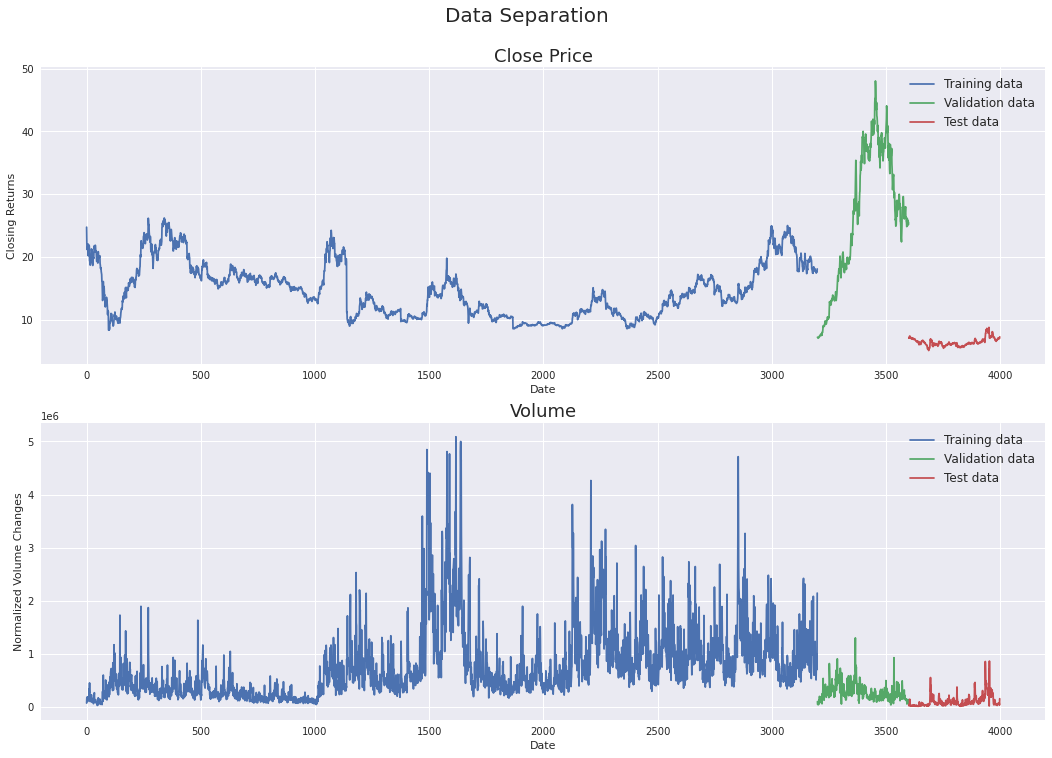

In [25]:
fig = plt.figure(figsize=(18,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Moving Average - Create chunks of training, validation, and test data

In [26]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

##############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

##############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (3072, 128, 9) (3072,)
Validation set shape (272, 128, 9) (272,)
Testing set shape (271, 128, 9) (271,)


In [27]:
X_test[0][0][:]

array([7.02000000e+00, 7.20000000e+00, 7.02000000e+00, 7.10000000e+00,
       7.01000000e+00, 9.00000000e-02, 1.28000000e+00, 3.28949000e+04,
       2.33798239e+04])

In [28]:
# # Training data
# X_train, y_train = [], []
# for i in range(seq_len, len(train_data)-5):
#   X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_train.append(train_data[:, 3][i+5]) #Value of 4th column (Close Price) of df-row 128+1
# X_train, y_train = np.array(X_train), np.array(y_train)

# ###############################################################################

# # # Validation data
# # X_val, y_val = [], []
# # for i in range(seq_len, len(val_data)):
# #     X_val.append(val_data[i-seq_len:i])
# #     y_val.append(val_data[:, 3][i])
# # X_val, y_val = np.array(X_val), np.array(y_val)

# ###############################################################################

# # Test data
# X_test, y_test = [], []
# for i in range(seq_len, len(test_data)-5):
#     X_test.append(test_data[i-seq_len])
#     y_test.append(test_data[:, 3][i+5])
# X_test, y_test = np.array(X_test), np.array(y_test)

# print(X_train.shape, y_train.shape)
# # print(X_val.shape, y_val.shape)

In [29]:
print(X_test.shape)

(271, 128, 9)


## Moving Average - Model

In [30]:
# X_train[0]

In [31]:
y_test.shape

(271,)

In [32]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  normall = LayerNormalization(axis=2)
  normal_first = LayerNormalization(axis=-1)
  # input_shape = (2,seq_len,7)
  '''Construct model'''
  in_seq = Input(shape=(seq_len, 9))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = normal_first(x)
  x = normall(x)
  x = attn_layer1((x, x, x))
  
  x = normall(x)
  # x = sce2(x)
  # print(x.shape)
  x = attn_layer2((x, x, x))
  x = normall(x)
  # x = sce2(x)
  x = attn_layer3((x, x, x))
  
  x = normall(x)
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mape', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./Transformer+TimeEmbedding_sz.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
#                                               monitor='mae', 
#                                               save_best_only=False, verbose=1)



2021-12-08 21:30:47.793295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:1b:00.0
2021-12-08 21:30:47.798575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:1c:00.0
2021-12-08 21:30:47.801034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:60:00.0
2021-12-08 21:30:47.804466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:62:00.0
2021-12-08 21:30:47.807275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 4 with properties: 
name: Tesla V100-SXM2-32GB maj

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 11)      0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
layer_normalization_1 (LayerNor (None, 128, 11)      22          concatenate[0][0]            

In [33]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=300,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))



Train on 3072 samples, validate on 272 samples
Epoch 1/300


2021-12-08 21:32:52.866721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-08 21:33:04.880240: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


 256/3072 [=>............................] - ETA: 33:52 - loss: 99.9838 - mae: 14.5528 - mape: 99.9838  

In [ ]:
model = tf.keras.models.load_model('./Transformer+TimeEmbedding_sz.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

In [ ]:
y_train.shape[0]

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Tesla Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Tesla Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Tesla Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Tesla Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Tesla Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Tesla Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Tesla Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Tesla Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Tesla Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Moving Average - Model metrics

In [ ]:
y_test[-1],test_pred[-1]

In [ ]:
y_train.size

In [ ]:
y_test.size

In [ ]:
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100
accuracies = [calculate_accuracy(df['Close'].iloc[-y_test.size:].values, r) for r in test_pred]
plt.figure(figsize = (15, 5))
plt.plot(test_pred[:y_test.size], label = 'forecast')
plt.plot(df['Close'].iloc[:y_test.size].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)